<h1>Цифровой прорыв — 2021. ФИНАЛ // Кейс Hyper AdTech</h1>
<h2>Решение по определению цифрового портрета аудитории в мобильной среде</h2>
___________________________________________________________________

`Big Data`  `Data Science`

<h3>Команда DST-OFF<span class=\"tocSkip\"></span></h3>

# Постановка задачи
Рекламная платформа Hyper AdTech, специализирующаяся на размещении видеорекламы в мобильных приложениях, поставила задачу создать решение, которое позволило бы максимально точно определить профиль аудитории в  мобильной среде на основе различных косвенных и исторических аудиторных данных.

Для решения кейса вам доступны модельные данные. Данные состоят из:
* Сегментов целевых аудиторий — они параметризуются социально-демографическими атрибутами и/или тематическими интересами Истории активности пользователей в мобильных приложениях — это идентификатор приложения, время и географическая локация 
* Панелистов — каждый панелист принадлежит хотя бы одному сегменту, а действия панелиста размечены в истории активности его сегментами 
* Идентификаторов мобильных устройств, пользователей и панелистов в модельных данных нет. 

Ваша задача — разметить историю активности так, чтобы проставить везде недостающие сегменты.

В рамках кейса  необходимо решить следующие задачи:
1. Обучить классификатор предсказывать сегмент по признакам на тренировочной выборке и проверить работу классификатора на тестовой выборке, в которой отсутствуют метки сегментов;
2. Используя таблицу признаков, кластеризовать пользователей и сравнить найденные кластеры с сегментами, представленными в Dataset.

## Требования к результату
Программное решение, которое
1. на входе получает набор проверочных данных, и
2. выводит таблицу охвата (доля сегмента, или же вероятность получить сегмент в трафике).

Результат по первой задаче:
* Алгоритм, который на входе получает информацию о признаках трафика (категория приложения, время и местоположение пользователя) и на выходе определяет сегменты, к которым принадлежат пользователи
Результат нужно представить в виде таблицы с двумя колонками, где первая колонка - это соответствующий номер записи, а вторая колонка - это предсказанный сегмент.

Результат по второй задаче:
* Алгоритм, который на входе получает аналогичную п.1 информацию о признаках трафика, и выводит:
   * процентное отношение количества каждого определенного вами кластера. Кроме того необходимо обосновать полученный результат, то есть описать признаки трафика, который принадлежит выделенному вами кластеру. По возможности также нужно обосновать результат; если это предполагает выбранный вами алгоритм, то дополнительно выявленными вами признаками принадлежности к кластеру. 
   
Требование к презентации результата:
* Представить процент охвата по сегментам. Для этого нужно посчитать какой процент каждый из типов предсказанных сегментов занимает по отношению ко всей тестовой выборке. 

Поправка:
* Для кластеризации нужен массив размера (n x 5) (с вероятностями классов, n - размер тестовой выборки)
* Таблица по % охватам нужна для задачи кластеризации, её следует привести в презентации вашего решения

# Описание решения

* Изучение данных (этот блокнот)
* Разделение тренировочного и тестового датасетов по дням (блокнот 01-split_csv.ipynb)
* Обучение дневных моделей и предсказание результатов по дням  (блокнот 02-random-forest.ipynb)
* Соединение результатов по дням в общий файл resuls.zip (блокнот 03-result_concate.ipynb)

Ход решения представлен ниже.

In [1]:
#!c1.8
%pip install -U pip icecream seaborn

Defaulting to user installation because normal site-packages is not writeable


In [2]:
#!c1.8
import pandas as pd
import numpy as np

import os

import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from icecream import ic

In [3]:
#!c1.8
ic()
df = pd.read_csv('train.csv.zip')
ic()

ic| <ipython-input-3-3bf864640db9>:1 in <module> at 22:12:08.171
ic| <ipython-input-3-3bf864640db9>:3 in <module> at 22:13:41.016


In [4]:
#!c1.8
ic()
display(df.info(null_counts=True))
ic()

ic| <ipython-input-4-bd9baf3193f4>:1 in <module> at 22:15:03.748


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44854516 entries, 0 to 44854515
Data columns (total 10 columns):
Segment            44854516 non-null int64
gamecategory       27893185 non-null object
subgamecategory    27886091 non-null object
bundle             44837232 non-null object
created            44854516 non-null object
shift              41263366 non-null object
oblast             41399238 non-null object
city               40054524 non-null object
os                 44854283 non-null object
osv                44854233 non-null object
dtypes: int64(1), object(9)
memory usage: 3.3+ GB


None

ic| <ipython-input-4-bd9baf3193f4>:3 in <module> at 22:15:17.549


In [5]:
#!c1.8
ic()
display(df.describe(include='all'))
ic()

ic| <ipython-input-5-83fcf1c675ca>:1 in <module> at 22:15:20.189


,Segment,gamecategory,subgamecategory,bundle,created,shift,oblast,city,os,osv
count,4.485452e+07,27893185,27886091,44837232,44854516,41263366,41399238,40054524,44854283,44854233
unique,NaN,27,53,85797,1720033,11,90,2498,4,254
top,NaN,Games,Puzzle,com.fugo.wow,1970-01-01 03:00:00,MSK,Москва,Москва,android,10.0
freq,NaN,24555534,4691498,1678124,233,26308751,7680369,7644426,35245849,9447724
mean,3.942103e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.003665e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,3.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,4.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,5.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


ic| <ipython-input-5-83fcf1c675ca>:3 in <module> at 22:16:27.080


In [41]:
#!c1.8
ic()
pd.set_option('display.max_rows', 10)
display(df[df.created=='1970-01-01 03:00:00'])

ic| <ipython-input-41-d07ac7d3ece7>:1 in <module> at 22:58:19.511


,Segment,gamecategory,subgamecategory,bundle,created,shift,oblast,city,os,osv,date,month,weekdayid,weekday
444051,4,NaN,NaN,NaN,1970-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,1970-01-01,1,3,Чт
826581,4,NaN,NaN,NaN,1970-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,1970-01-01,1,3,Чт
835484,3,NaN,NaN,NaN,1970-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,1970-01-01,1,3,Чт
1329799,4,NaN,NaN,NaN,1970-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,1970-01-01,1,3,Чт
2946205,4,NaN,NaN,NaN,1970-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,1970-01-01,1,3,Чт
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44155424,4,NaN,NaN,NaN,1970-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,1970-01-01,1,3,Чт
44181051,5,NaN,NaN,NaN,1970-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,1970-01-01,1,3,Чт
44403110,4,NaN,NaN,NaN,1970-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,1970-01-01,1,3,Чт
44600146,4,NaN,NaN,NaN,1970-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,1970-01-01,1,3,Чт


In [8]:
#!c1.8
ic()
df['date'] = pd.to_datetime(df.created).dt.date
df['month'] = pd.to_datetime(df.created).dt.month
display(df.nunique())
ic()

ic| <ipython-input-8-83228a03524e>:1 in <module> at 22:17:18.433


Segment                  5
gamecategory            27
subgamecategory         53
bundle               85797
created            1720033
shift                   11
oblast                  90
city                  2498
os                       4
osv                    254
date                    21
month                    4
dtype: int64

ic| <ipython-input-8-83228a03524e>:5 in <module> at 22:18:46.438


In [9]:
#!c1.8
display(df['date'].value_counts().sort_index())

1970-01-01        233
2021-07-05    1851608
2021-07-06    1521102
2021-07-07    1287756
2021-07-08    1374243
2021-07-09    1528335
2021-07-10    1401110
2021-07-11    1337398
2021-08-02    4629299
2021-08-03    4425717
2021-08-04    4098399
2021-08-05    1917581
2021-08-06    1671776
2021-08-07    1516160
2021-08-08    1437700
2021-09-15    2274243
2021-09-16    2402905
2021-09-17    2816242
2021-09-18    2775226
2021-09-19    2408820
2021-09-20    2178663
Name: date, dtype: int64

In [39]:
#!c1.8
ic()
pd.options.display.float_format = '{:.1f}'.format
display(df.Segment.value_counts(normalize=True).sort_index()*100)

ic| <ipython-input-39-975853259c05>:1 in <module> at 22:57:16.596


1    2.1
2    3.2
3   31.6
4   24.8
5   38.3
Name: Segment, dtype: float64

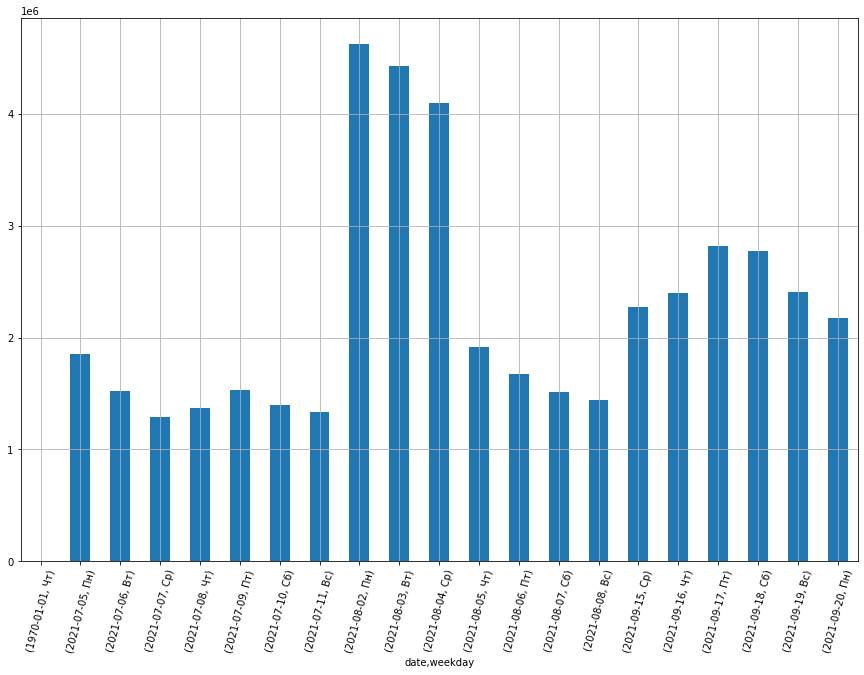

In [35]:
#!c1.8

# Выделим номер дня недели
df['weekdayid'] = pd.to_datetime(df.date).dt.weekday

# Для наглядности определим текстовую метку дня недели
df['weekday'] = df.weekdayid.map({0: 'Пн', 1: 'Вт', 2: 'Ср', 3: 'Чт', 4: 'Пт', 5: 'Сб', 6: 'Вс'})
ax = df.groupby(by=['date', 'weekday']).date.count().plot(grid=True, kind='bar', figsize=(15, 10), rot=75)
plt.show()

In [14]:
#!c1.8
ic()
display(df.gamecategory.value_counts())
ic()

ic| <ipython-input-14-c889fb4ae3ee>:1 in <module> at 22:23:20.834


Games                 24555534
Applications           2742231
Lifestyle               267292
Shopping                184875
Entertainment            31465
Social Networking        28931
Education                27008
Book                     23483
Photo & Video            10235
Utilities                 7560
Music                     4571
IAB9-30                   3474
Health & Fitness          1423
Finance                   1322
Productivity              1314
Travel                     778
Sports                     614
Navigation                 332
Reference                  235
IAB9,IAB9-30,games         226
Graphics & Design           73
Business                    67
Medical                     66
Food & Drink                44
News                        23
Weather                      5
Stickers                     4
Name: gamecategory, dtype: int64

ic| <ipython-input-14-c889fb4ae3ee>:3 in <module> at 22:23:24.009


In [15]:
#!c1.8
ic()
display(df.subgamecategory.value_counts())
ic()

ic| <ipython-input-15-0412fedf0cc9>:1 in <module> at 22:23:25.045

Puzzle                     4691498
Action                     3412940
Casual                     3242897
Simulation                 2757136
Word                       1827741
Arcade                     1372731
Strategy                   1276408
Role Playing               1202308
Card                       1041830
Board                       883606
Racing                      812515
Adventure                   736299
Tools                       666860
None                        647453
Sports                      576169
Dating                      296753
Shopping                    287733
Music                       286998
Productivity                222971
Entertainment               218854
Books & Reference           211505
Health & Fitness            176483
Video Players & Editors     151221
Casino                      149003
Trivia                      134411
Music & Audio               115483
Education                    86473
Family                       77440
Social              


ic| <ipython-input-15-0412fedf0cc9>:3 in <module> at 22:23:28.192


In [16]:
#!c1.8
ic()
display(df.bundle.value_counts()[df.bundle.value_counts()>5000])
ic()

ic| <ipython-input-16-0d23ab9ebb75>:1 in <module> at 22:23:28.998


com.fugo.wow                                       1678124
net.wargaming.wot.blitz                            1101717
com.openmygame.games.android.wordpizza              902581
com.axlebolt.standoff2                              632030
com.yourstoryinteractive.sails.pirate.adventure     491705
                                                    ...   
com.creativejoy.fruitwonderland                       5042
Draziw.Button.Mines                                   5035
com.codigames.idle.fitness.gym.tycoon                 5033
1560113405                                            5015
com.gramgames.mergemagic                              5002
Name: bundle, Length: 1219, dtype: int64

ic| <ipython-input-16-0d23ab9ebb75>:3 in <module> at 22:23:39.868


In [17]:
#!c1.8
topgames = df.bundle.value_counts()[:20].index
df_topgames = df[df.bundle.isin(topgames)]
ic()
len(df_topgames)

ic| <ipython-input-17-951a04d658d5>:3 in <module> at 22:32:03.862


9466545

In [18]:
#!c1.8
ic()
tdf = df_topgames.groupby(by=['bundle', 'date']).date.count().unstack().fillna(0)
ic()
display(tdf/tdf.sum()*100)

ic| <ipython-input-18-442a114a51d0>:1 in <module> at 22:32:13.419
ic| <ipython-input-18-442a114a51d0>:3 in <module> at 22:32:15.332


date,2021-07-05,2021-07-06,2021-07-07,2021-07-08,2021-07-09,2021-07-10,2021-07-11,2021-08-02,2021-08-03,2021-08-04,2021-08-05,2021-08-06,2021-08-07,2021-08-08,2021-09-15,2021-09-16,2021-09-17,2021-09-18,2021-09-19,2021-09-20
bundle,,,,,,,,,,,,,,,,,,,,
1300588558,5.168971,4.925362,5.264885,4.409369,4.525156,5.130520,4.511289,1.344369,1.566629,1.601638,2.236062,2.125242,1.723799,2.342155,2.832333,2.699208,2.573750,2.950198,2.709569,3.052042
351331194,3.037752,3.215684,3.737847,3.355548,4.243666,5.049244,4.735800,1.478657,1.682874,1.659180,2.360197,2.333360,1.914037,2.749528,3.117000,3.031865,2.722200,2.876551,3.387747,3.521711
com.Seriously.BestFiends,1.362463,1.414238,1.454600,1.751432,2.452119,2.547699,2.504061,1.932649,2.098311,2.122579,1.787873,1.597250,1.963744,1.881800,2.365536,2.793760,2.735082,2.766947,3.033778,2.972332
com.allgoritm.youla,0.062565,0.037982,0.070164,0.032997,0.026343,0.025544,0.026133,0.011638,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.023591,10.240106,10.735442,11.069522,11.490565,13.221847
com.axlebolt.standoff2,4.046787,3.923058,4.229319,5.378230,5.680969,5.968529,5.811132,11.797228,12.840585,12.773380,9.653026,8.504420,10.415516,9.598958,0.559057,1.301638,0.648396,0.308449,0.112506,0.199945
com.fidgettrading.game,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.554746,3.173686,3.468967,4.092743,4.922354,6.048026,5.354005,1.149425,1.097812,1.357317,1.339936,1.337001,0.885124
com.fingerlab.word.blockpuzzles,1.908912,1.733385,2.190670,2.678203,3.078822,3.020548,3.412496,4.169485,3.970566,4.062885,4.264766,5.011813,4.964284,4.725338,4.933040,4.435186,3.005605,2.391783,2.809251,2.705561
com.fugo.wow,33.403516,34.912158,31.268049,39.831118,35.256426,29.081267,30.184449,12.106885,12.598980,12.548774,11.808888,11.418332,13.176418,13.656217,9.265434,10.066416,10.295203,10.506775,11.344913,11.171408
com.iposedon.bricksbreakerballs,7.641416,7.357964,6.024018,0.532627,0.560219,0.650495,0.601961,5.048821,3.883274,3.356267,3.568772,3.793634,3.118978,3.116520,2.124130,2.219779,2.190969,1.996474,1.336033,2.280175


In [19]:
#!c1.8
ic()
topsubgamecategory = df.subgamecategory.value_counts()[:25].index
df_topsubgamecategory = df[df.subgamecategory.isin(topsubgamecategory)]
tdf = df_topsubgamecategory.groupby(by=['subgamecategory', 'date']).date.count().unstack().fillna(0)
ic()
tdf['Итого топ25'] = tdf.sum(axis=1)
tdf.sort_values('Итого', ascending=False, inplace=True)
ic()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.1f}'.format
display(tdf/tdf.sum()*100)

ic| <ipython-input-19-0d6ca08f9fc9>:1 in <module> at 22:32:16.115
ic| <ipython-input-19-0d6ca08f9fc9>:5 in <module> at 22:32:28.198
ic| <ipython-input-19-0d6ca08f9fc9>:8 in <module> at 22:32:28.217


date,2021-07-05,2021-07-06,2021-07-07,2021-07-08,2021-07-09,2021-07-10,2021-07-11,2021-08-02,2021-08-03,2021-08-04,2021-08-05,2021-08-06,2021-08-07,2021-08-08,2021-09-15,2021-09-16,2021-09-17,2021-09-18,2021-09-19,2021-09-20,Итого
subgamecategory,,,,,,,,,,,,,,,,,,,,,
Puzzle,16.6,16.8,17.3,16.9,17.2,17.2,17.3,17.4,17.2,17.1,17.7,17.7,17.5,17.6,17.3,17.5,16.9,16.4,17.1,17.5,17.2
Action,11.7,11.5,11.4,11.7,11.5,11.8,12.4,15.1,14.6,14.6,14.0,14.0,14.4,14.3,10.3,10.1,10.6,11.4,11.1,10.0,12.5
Casual,12.0,12.3,12.9,12.8,12.8,12.7,12.7,11.8,12.0,12.0,11.7,12.1,12.6,12.5,10.9,10.9,11.5,11.8,11.9,11.0,11.9
Simulation,12.3,11.7,11.7,11.5,11.7,11.8,11.5,8.9,9.0,9.0,9.1,9.3,9.4,9.5,10.0,9.8,10.6,11.2,10.8,9.9,10.1
Word,5.8,5.9,5.6,6.0,6.1,6.0,6.0,7.1,7.2,7.2,7.1,6.8,7.0,7.0,6.7,7.0,6.6,6.2,6.5,6.8,6.7
Arcade,5.1,5.1,4.9,5.5,5.4,5.4,5.3,5.1,5.1,5.1,4.6,4.8,5.5,5.1,4.9,4.6,4.9,5.1,5.0,4.4,5.0
Strategy,4.7,4.7,4.6,4.7,4.8,4.7,4.6,5.0,4.9,5.0,5.1,4.5,4.3,4.3,4.9,4.6,4.4,4.3,4.2,4.7,4.7
Role Playing,6.6,6.4,6.3,5.4,5.3,5.3,5.2,3.9,4.0,4.2,4.2,4.3,3.8,3.9,4.3,4.3,4.1,4.1,4.0,4.2,4.4
Card,3.2,3.3,3.3,3.3,3.3,3.2,3.3,3.6,3.7,3.7,3.8,3.6,3.3,3.4,4.7,4.7,4.4,4.0,4.0,4.5,3.8


/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/core.py:1182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


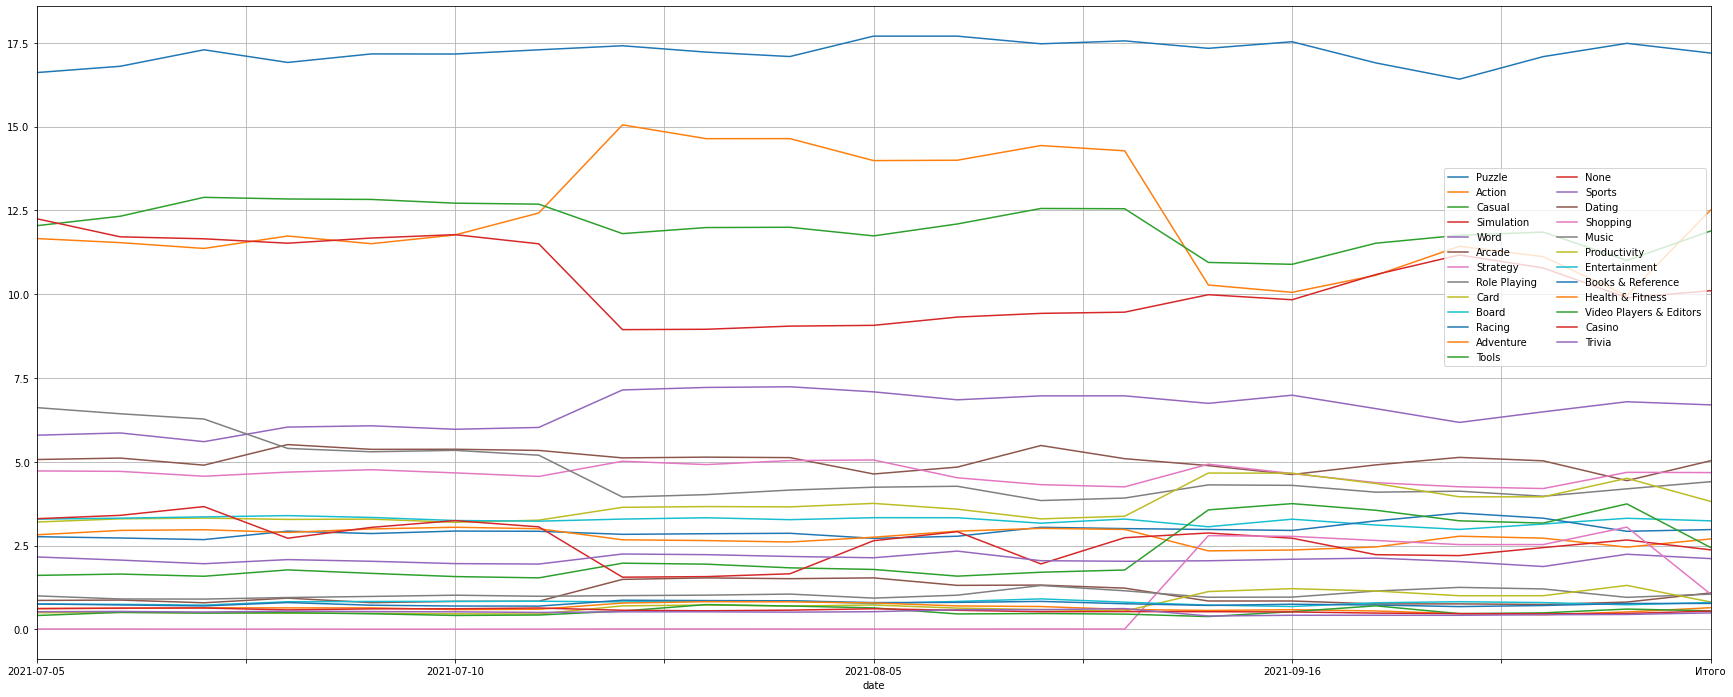

In [20]:
#!c1.8
display((tdf/tdf.sum()*100).T.plot(grid=True, figsize=(30,12)).legend(loc='right', bbox_to_anchor=(1, 0.6), ncol=2))

In [21]:
#!c1.8
ic()
topoblast = df.oblast.value_counts()[:25].index
df_topoblast = df[df.oblast.isin(topoblast)]
tdf = df_topoblast.groupby(by=['oblast', 'date']).date.count().unstack().fillna(0)
ic()
tdf['Итого топ25'] = tdf.sum(axis=1)
tdf.sort_values('Итого', ascending=False, inplace=True)
ic()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.1f}'.format
display(tdf/tdf.sum()*100)

ic| <ipython-input-21-960c1d02ae60>:1 in <module> at 22:32:56.505
ic| <ipython-input-21-960c1d02ae60>:5 in <module> at 22:33:12.354
ic| <ipython-input-21-960c1d02ae60>:8 in <module> at 22:33:12.377


date,2021-07-05,2021-07-06,2021-07-07,2021-07-08,2021-07-09,2021-07-10,2021-07-11,2021-08-02,2021-08-03,2021-08-04,2021-08-05,2021-08-06,2021-08-07,2021-08-08,2021-09-15,2021-09-16,2021-09-17,2021-09-18,2021-09-19,2021-09-20,Итого
oblast,,,,,,,,,,,,,,,,,,,,,
Москва,23.7,24.3,24.7,24.9,24.4,23.2,22.6,22.2,22.3,22.2,23.0,23.0,21.6,21.4,23.1,22.5,22.3,21.4,22.6,23.1,22.7
Свердловская область,9.5,9.3,8.9,8.9,9.3,9.6,9.5,8.8,8.8,8.9,9.0,8.9,9.0,9.3,9.3,9.6,9.4,9.2,8.8,9.2,9.1
Санкт-Петербург,9.1,9.2,9.3,9.6,9.8,9.5,9.3,9.5,9.1,8.9,9.0,9.0,9.0,8.4,9.3,8.8,8.8,8.7,9.0,8.8,9.1
Краснодарский край,10.3,9.8,10.1,10.1,10.0,10.1,9.8,9.0,9.1,9.1,8.9,9.0,9.4,9.1,7.9,7.8,7.7,7.6,8.0,7.8,8.9
Татарстан,5.8,5.7,5.6,5.9,5.9,6.0,5.9,6.7,6.8,6.9,6.7,6.7,6.9,6.7,7.3,7.1,7.1,6.9,6.7,6.9,6.6
Новосибирская область,5.5,5.8,5.5,5.2,5.5,5.7,5.9,4.7,4.6,4.8,4.8,4.8,4.6,4.9,4.8,5.0,4.9,5.2,4.9,5.3,5.0
Самарская область,4.8,4.9,4.8,5.1,5.0,5.0,5.0,4.7,4.8,4.7,4.6,4.6,4.8,4.7,4.6,4.6,4.6,4.5,4.3,4.4,4.7
Ростовская область,3.1,3.0,3.0,2.9,3.0,3.0,3.0,3.5,3.5,3.5,3.4,3.4,3.5,3.4,3.1,3.0,3.0,3.1,3.2,3.0,3.2
Московская область,2.9,2.9,3.1,2.9,2.9,2.9,2.9,2.7,2.6,2.7,2.9,3.0,3.0,2.9,2.9,2.9,3.1,3.3,3.6,3.1,2.9


/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/core.py:1182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


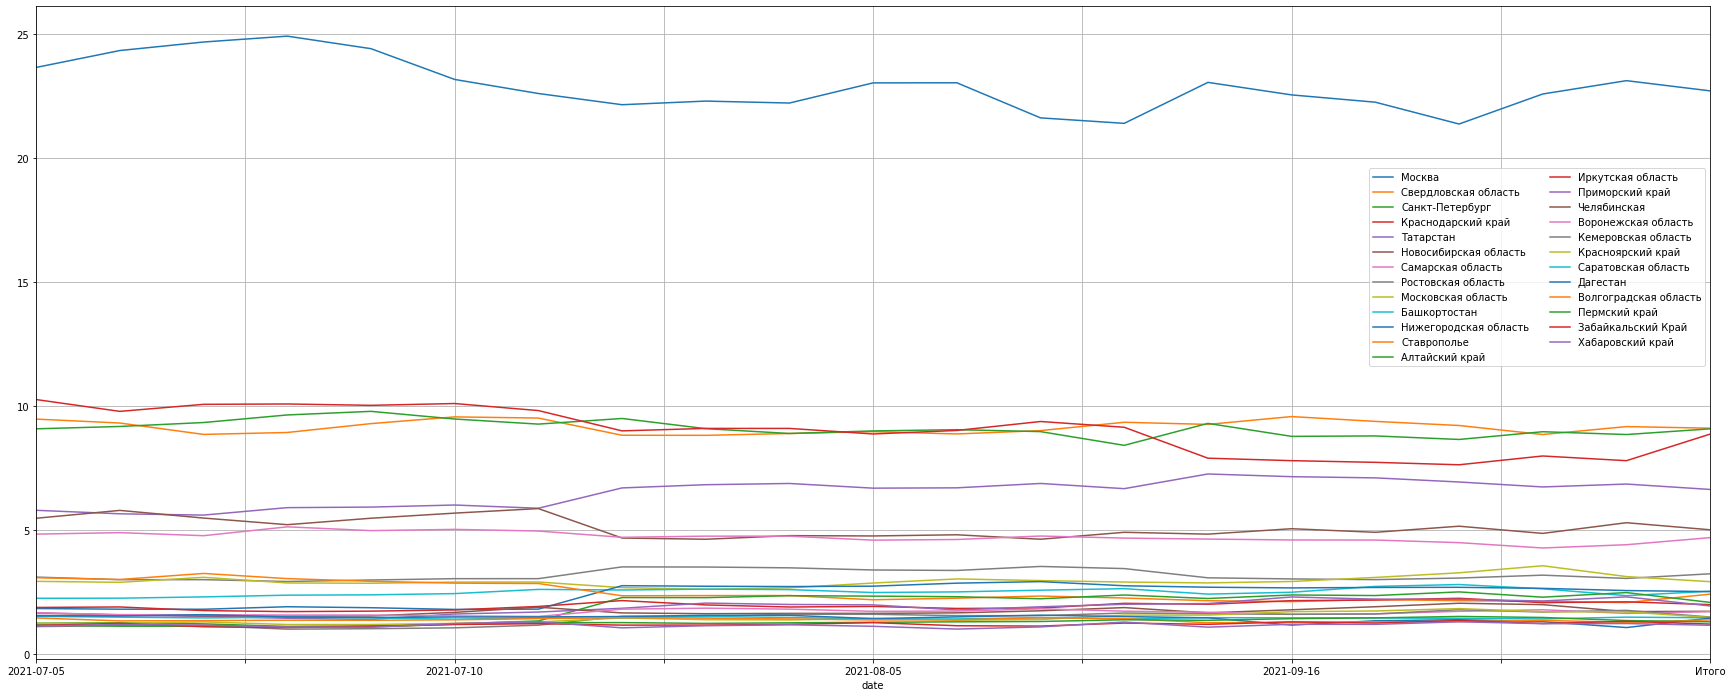

In [22]:
#!c1.8
display((tdf/tdf.sum()*100).T.plot(grid=True, figsize=(30,12)).legend(loc='right', bbox_to_anchor=(1, 0.6), ncol=2))

In [23]:
#!c1.8
ic()
topoblast = df.oblast.value_counts()[:25].index
df_topoblast = df[df.oblast.isin(topoblast)]
tdf = df_topoblast.groupby(by=['Segment', 'oblast']).date.count().unstack().fillna(0)
ic()
tdf.sort_values(5, ascending=False, axis=1, inplace=True)
tdf['Итого топ25'] = tdf.sum(axis=1)
ic()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.1f}'.format
display((tdf/tdf.sum()*100).T)

ic| <ipython-input-23-e17b1b2e10f3>:1 in <module> at 22:33:48.596
ic| <ipython-input-23-e17b1b2e10f3>:5 in <module> at 22:34:03.941
ic| <ipython-input-23-e17b1b2e10f3>:8 in <module> at 22:34:03.962


Segment,1,2,3,4,5
oblast,,,,,
Москва,2.0,2.8,33.2,24.4,37.6
Свердловская область,2.1,3.4,31.2,24.9,38.4
Санкт-Петербург,2.0,2.8,32.9,24.7,37.6
Краснодарский край,2.2,2.6,33.6,25.4,36.1
Татарстан,1.9,3.3,30.9,24.9,39.0
Новосибирская область,2.2,3.4,30.8,24.2,39.4
Самарская область,2.1,3.1,31.7,26.1,36.9
Ростовская область,1.9,3.0,31.8,25.6,37.8
Московская область,2.0,3.0,34.1,24.2,36.8


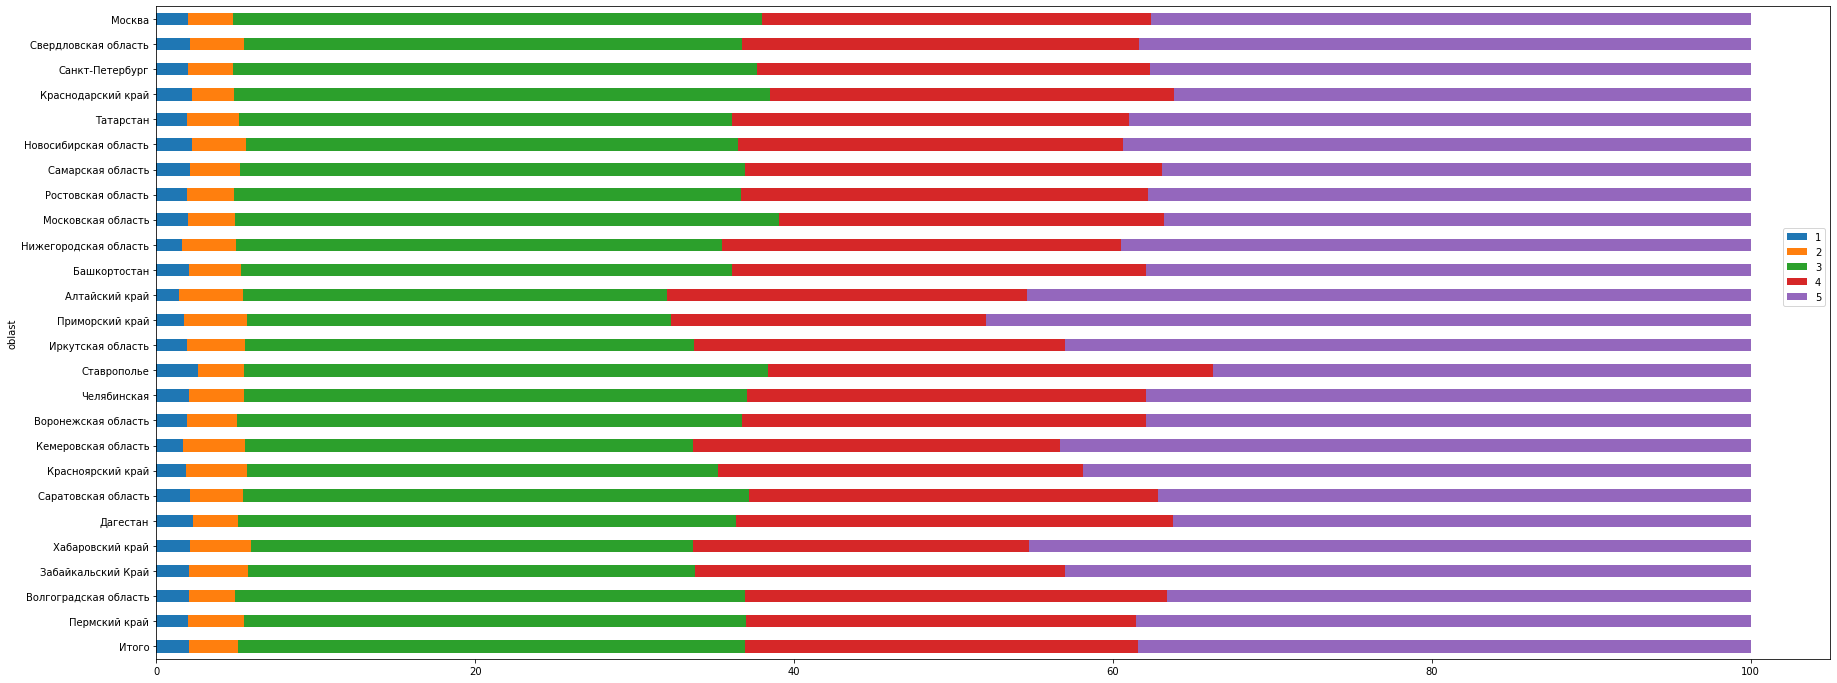

In [24]:
#!c1.8
display((tdf/tdf.sum()*100).T[::-1].plot.barh(stacked=True, figsize=(30,12)).legend(loc='right', bbox_to_anchor=(1, 0.6)))

In [25]:
#!c1.8
ic()
topoblast = df.oblast.value_counts()[:25].index
df_topoblast = df[df.oblast.isin(topoblast)]
tdf = df_topoblast.groupby(by=['month', 'Segment', 'oblast']).date.count().unstack().fillna(0)
ic()
tdf.sort_values((9, 5), ascending=False, axis=1, inplace=True)
tdf['Итого топ25'] = tdf.sum(axis=1)
ic()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.1f}'.format
display((tdf/tdf.sum(level=0)*100).T)

ic| <ipython-input-25-c631256398eb>:1 in <module> at 22:34:06.933
ic| <ipython-input-25-c631256398eb>:5 in <module> at 22:34:22.954
ic| <ipython-input-25-c631256398eb>:8 in <module> at 22:34:22.981


month                   7              8             9                    
Segment                 1    3    4    3    4    5   1    2    3    4    5
oblast                                                                    
Москва                6.5 57.0 36.5 24.4 27.5 48.2 1.3  8.6 27.3 11.6 51.2
Свердловская область  7.2 52.1 40.8 22.1 27.3 50.6 1.4 10.1 28.5 10.8 49.2
Санкт-Петербург       6.6 55.8 37.6 24.4 27.6 48.0 1.4  8.7 27.7 11.3 50.8
Краснодарский край    7.0 54.5 38.5 25.0 26.9 48.2 1.4  9.1 28.7 11.4 49.4
Татарстан             7.0 52.0 40.9 23.2 27.9 48.9 1.4  9.5 28.8 11.7 48.6
Новосибирская область 7.2 52.9 39.9 20.0 26.5 53.5 1.2 10.4 27.6  9.1 51.7
Самарская область     6.9 52.7 40.4 22.6 28.3 49.1 1.5  9.9 28.6 12.4 47.7
Московская область    6.5 59.9 33.6 25.7 28.5 45.8 1.4  8.3 27.5 13.1 49.7
Ростовская область    6.9 55.1 38.0 23.7 28.3 48.0 1.5  9.5 28.2 12.9 47.9
Нижегородская область 6.8 54.6 38.6 23.5 29.0 47.6 1.5  9.7 28.7 13.2 47.0
Приморский край       7.6 53.0 39.3 17.4 22.4 60.2 1.0 10.4 24.8  7.2 56.6
Алтайский край        7.3 52.9 39.7 19.1 27.1 53.8 1.3 10.5 27.1 10.7 50.5
Башкортостан          7.1 52.8 40.1 21.6 28.9 49.5 1.5  9.7 29.3 13.2 46.3
Иркутская область     7.4 52.8 39.7 17.9 26.2 55.9 1.1 10.3 26.4 10.0 52.2
Ставрополье           7.7 52.1 40.3 23.3 29.3 47.5 1.5  9.9 28.3 13.9 46.4
Челябинская           6.8 54.5 38.6 22.1 28.6 49.2 1.5  9.8 28.9 12.5 47.2
Красноярский край     7.0 55.0 38.0 19.7 27.3 53.0 1.3 10.0 27.8 10.5 50.4
Кемеровская область   7.2 54.1 38.7 19.3 27.2 53.5 1.4 10.4 27.5 10.8 50.1
Воронежская область   7.0 54.2 38.8 23.3 28.2 48.5 1.5  9.5 29.1 12.6 47.3
Саратовская область   7.0 54.0 39.0 22.7 28.4 48.9 1.6 10.0 28.5 12.6 47.3
Забайкальский Край    7.4 51.4 41.2 18.1 25.9 56.1 1.2 10.6 25.8  8.7 53.7
Хабаровский край      7.6 53.2 39.2 16.6 22.7 60.6 1.0 11.1 24.6  7.0 56.2
Пермский край         7.0 54.8 38.1 22.6 28.1 49.4 1.5  9.8 29.2 12.6 47.0
Волгоградская область 7.0 54.0 39.1 23.4 29.0 47.6 1.5  9.3 28.4 13.5 47.3
Дагестан              8.0 52.5 39.5 23.3 29.0 47.7 1.3  9.6 26.6 15.2 47.4
Итого                 6.9 54.6 38.5 22.9 27.5 49.6 1.4  9.4 27.9 11.5 49.9

In [33]:
#!c1.8
ic()
topsubgamecategory = df.subgamecategory.value_counts()[:25].index
df_topsubgamecategory = df[df.subgamecategory.isin(topsubgamecategory)]
tdf = df_topsubgamecategory.groupby(by=['month', 'Segment', 'subgamecategory']).date.count().unstack().fillna(0)
tdf.sort_values((9, 5), ascending=False, axis=1, inplace=True)
tdf['Итого топ25'] = tdf.sum(axis=1)
ic()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.1f}'.format
display((tdf/tdf.sum(level=0)*100).T)

ic| <ipython-input-33-b9eb365a92b1>:1 in <module> at 22:51:44.764
ic| <ipython-input-33-b9eb365a92b1>:7 in <module> at 22:51:57.146


month                     7              8             9                   
Segment                   1    3    4    3    4    5   1    2    3   4    5
subgamecategory                                                            
Puzzle                  4.7 62.4 32.9 28.1 21.8 50.1 0.4  8.9 29.3 5.2 56.3
Casual                  4.7 61.1 34.2 29.2 20.8 50.0 0.5  9.5 29.9 4.9 55.1
Action                  4.6 59.6 35.8 26.7 20.8 52.5 0.4 10.0 28.8 5.2 55.6
Simulation              4.6 61.9 33.5 29.0 20.4 50.6 0.6  9.7 28.1 5.0 56.5
Word                    5.1 56.1 38.8 26.3 22.4 51.4 0.4  9.6 28.1 5.7 56.2
Strategy                4.4 61.1 34.5 25.2 20.7 54.1 1.0 10.4 24.9 4.6 59.1
Arcade                  5.2 52.3 42.6 25.5 22.8 51.7 0.5 11.0 30.7 6.1 51.7
Card                    4.7 60.2 35.1 26.0 22.4 51.6 0.4  9.9 26.7 5.2 57.8
Role Playing            4.1 72.9 23.1 29.1 19.5 51.4 0.6  9.2 26.1 4.4 59.6
Tools                   5.4 48.2 46.4 22.0 25.0 53.0 0.1 10.2 26.9 5.7 57.1
None                    3.0 91.1  6.0 47.8  8.2 44.0 0.0  3.0 24.0 0.6 72.4
Board                   4.9 60.4 34.7 28.1 22.3 49.6 0.2  8.4 30.7 5.6 55.1
Racing                  5.1 55.7 39.2 25.9 22.3 51.8 0.2 10.0 30.8 5.8 53.2
Shopping                4.5 47.7 47.7 22.0 26.3 51.7 0.1 10.4 29.9 6.4 53.1
Adventure               4.5 64.9 30.6 30.1 20.4 49.5 0.3  9.1 30.4 4.9 55.2
Sports                  5.4 52.0 42.6 20.3 23.8 55.9 0.4 10.4 20.1 6.2 62.9
Productivity            5.1 51.0 43.9 22.1 25.5 52.5 0.1 11.1 25.8 5.2 57.8
Music                   5.5 49.5 45.0 25.3 23.3 51.3 0.1 11.1 33.2 6.2 49.4
Dating                  5.5 47.5 47.0 22.5 24.9 52.5 0.1 10.8 26.7 6.1 56.4
Entertainment           5.2 51.9 43.0 25.5 23.5 50.9 0.6 10.6 30.1 6.7 52.0
Books & Reference       5.5 46.4 48.1 23.5 26.9 49.6 0.1 10.2 30.0 7.0 52.8
Casino                  4.3 65.3 30.4 28.0 19.8 52.2 0.6  9.6 25.0 4.4 60.5
Health & Fitness        5.7 51.9 42.3 24.8 24.4 50.7 0.1 10.3 28.8 5.2 55.7
Video Players & Editors 5.7 48.1 46.3 21.7 25.6 52.6 0.1 11.5 28.8 6.1 53.6
Trivia                  5.0 60.7 34.3 30.1 21.6 48.2 0.2  8.4 34.1 5.5 51.9
Итого топ25             4.7 61.1 34.3 27.5 21.4 51.1 0.4  9.5 28.4 5.2 56.4

In [34]:
#!c1.8
ic()
topbundle = df.bundle.value_counts()[:25].index
df_topbundle = df[df.bundle.isin(topbundle)]
tdf = df_topbundle.groupby(by=['month', 'Segment', 'bundle']).date.count().unstack().fillna(0)
tdf.sort_values((9, 5), ascending=False, axis=1, inplace=True)
tdf['Итого топ25'] = tdf.sum(axis=1)
ic()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.1f}'.format
display((tdf/tdf.sum(level=0)*100).T.fillna(0))

ic| <ipython-input-34-66911affdcfa>:1 in <module> at 22:51:58.368
ic| <ipython-input-34-66911affdcfa>:7 in <module> at 22:52:09.752


month                                              7              8            \
Segment                                            1    3    4    3    4    5   
bundle                                                                          
com.allgoritm.youla                             25.7  0.0 74.3  0.0 76.9 23.1   
com.fugo.wow                                    14.9 11.4 73.7 21.2 31.8 47.1   
com.merge.cube.winner                            0.0  0.0  0.0 13.6 61.9 24.5   
net.wargaming.wot.blitz                          3.2 67.1 29.8 21.5 17.7 60.8   
com.openmygame.games.android.wordpizza           1.2 68.2 30.6 20.1 49.7 30.2   
com.smallgiantgames.empires                      4.6 57.7 37.7 24.9 20.8 54.3   
com.yourstoryinteractive.sails.pirate.adventure  4.6 53.7 41.7 25.7 21.7 52.6   
1016489154                                       0.0  0.0  0.0 46.1  7.9 46.0   
sortpuz.water.sort.puzzle.game                   5.7 49.6 44.6 25.0 24.8 50.2   
351331194                                        3.0 91.1  5.9 47.9  8.3 43.8   
com.openmygame.games.android.wordsearchsea       9.9 57.0 33.2 18.0 46.4 35.6   
com.nexters.herowars                             3.1 70.8 26.0 21.7 17.2 61.2   
1300588558                                       3.2 90.5  6.3 46.9  8.2 44.9   
com.fingerlab.word.blockpuzzles                  3.9 65.3 30.8 26.6 22.4 51.0   
com.Seriously.BestFiends                         3.9 62.8 33.3 26.9 21.0 52.1   
com.pixel.art.coloring.color.number             11.5 25.6 62.9 24.7 24.7 50.7   
com.supercell.hayday                             4.6 59.5 35.9 28.2 20.8 51.0   
com.wb.goog.mkx                                  3.3 66.5 30.2 21.9 18.1 60.0   
com.kiloo.subwaysurf                             3.5 65.8 30.7 26.1 17.4 56.4   
ru.photostrana.mobile                            5.6 48.2 46.2 23.1 25.1 51.7   
com.tilemaster.puzzle.block.match                3.7 67.9 28.4 27.4 18.3 54.3   
com.pronetis.ironball2                           3.7 64.0 32.3 28.1 19.5 52.4   
com.iposedon.bricksbreakerballs                  7.2 52.6 40.3  4.7 84.4 11.0   
com.fidgettrading.game                           0.0  0.0  0.0 29.8 20.2 50.0   
com.axlebolt.standoff2                           3.9 60.5 35.6 24.6 21.0 54.3   
Итого топ25                                      7.5 47.9 44.6 23.9 26.8 49.3   

month                                             9                      
Segment                                           1    2    3    4    5  
bundle                                                                   
com.allgoritm.youla                             0.1 10.6 29.7  6.3 53.2  
com.fugo.wow                                    0.4  9.8 29.1  6.3 54.4  
com.merge.cube.winner                           4.7  7.0 34.2 17.9 36.2  
net.wargaming.wot.blitz                         1.6 12.0 24.9  4.8 56.8  
com.openmygame.games.android.wordpizza          0.8 25.3 14.0  3.5 56.4  
com.smallgiantgames.empires                     1.3 11.2 23.1  4.4 59.9  
com.yourstoryinteractive.sails.pirate.adventure 1.4 10.5 24.1  5.1 58.8  
1016489154                                      0.0  3.2 24.6  0.6 71.6  
sortpuz.water.sort.puzzle.game                  0.1  9.1 30.9  7.0 52.9  
351331194                                       0.0  2.9 23.3  0.6 73.2  
com.openmygame.games.android.wordsearchsea      4.7  5.2 28.8 20.8 40.5  
com.nexters.herowars                            3.4  9.8 35.2  3.8 47.8  
1300588558                                      0.0  3.3 24.1  0.7 71.9  
com.fingerlab.word.blockpuzzles                 2.3  7.1 36.8  6.2 47.6  
com.Seriously.BestFiends                        2.0 10.5 28.0  4.8 54.7  
com.pixel.art.coloring.color.number             0.1  9.5 32.0  6.5 51.9  
com.supercell.hayday                            1.5 10.5 24.6  5.0 58.4  
com.wb.goog.mkx                                 3.7 10.1 32.2  3.8 50.1  
com.kiloo.subwaysurf                            5.3  8.7 37.5  4.3 44.2  
ru.photostrana.mobile 

In [42]:
#!c1.8
ic()
df = df[df.created!='1970-01-01 03:00:00']
df.created = pd.to_datetime(df.created)
df.fillna('', inplace=True)
df.subgamecategory = df.gamecategory + '/' + df.subgamecategory
df.city = df.oblast + '/' + df.city
df.osv = df.os + '/' + df.osv
df.os = df.os.str.lower()
ic()

ic| <ipython-input-42-065aa92c03fb>:1 in <module> at 22:59:06.062
ic| <ipython-input-42-065aa92c03fb>:9 in <module> at 23:00:37.239


In [43]:
#!c1.8
ic()
dfr = pd.DataFrame(columns = ['segment', '5min', 'weekdayid', 'month', 'gcid', 'sgcid', 'bid', 'tsid', 'oid', 'cid', 'osid', 'osvid'])

# Разобьем время на 15-минутные интервалы (условно-минималная сессия без прерываний видео)
# если в рамках одной сессии показано несколько видео, то фиксируем нескольких пользователей
dfr['5min'] = (df.created.sub(pd.to_datetime('2021-01-01')).dt.total_seconds() // 300).astype(int)
ic()

dfr['weekdayid'] = df.weekdayid
ic()

dfr['month'] = df.month
ic()

dfr['segment'] = df['Segment']
ic()
gamecategory_list = df['gamecategory'].unique()
gamecategory_to_gcid = dict(zip(gamecategory_list, np.arange(len(gamecategory_list))))
dfr['gcid'] = df['gamecategory'].map(gamecategory_to_gcid)
ic()
subgamecategory_list = df['subgamecategory'].sort_values().unique()
subgamecategory_to_sgcid = dict(zip(subgamecategory_list, np.arange(len(subgamecategory_list))))
dfr['sgcid'] = df['subgamecategory'].map(subgamecategory_to_sgcid)
ic()
bundle_list = df['bundle'].unique()
bundle_to_bid = dict(zip(bundle_list, np.arange(len(bundle_list))))
dfr['bid'] = df['bundle'].map(bundle_to_bid)
ic()
shift_list = df['shift'].unique()
shift_to_tsid = dict(zip(shift_list, np.arange(len(shift_list))))
dfr['tsid'] = df['shift'].map(shift_to_tsid)
ic()
oblast_list = df['oblast'].unique()
oblast_to_oid = dict(zip(oblast_list, np.arange(len(oblast_list))))
dfr['oid'] = df['oblast'].map(oblast_to_oid)
ic()
city_list = df['city'].unique()
city_to_cid = dict(zip(city_list, np.arange(len(city_list))))
dfr['cid'] = df['city'].map(city_to_cid)
ic()
os_list = df['os'].unique()
os_to_osid = dict(zip(os_list, np.arange(len(os_list))))
dfr['osid'] = df['os'].map(os_to_osid)
ic()
osv_list = df['osv'].unique()
osv_to_osvid = dict(zip(osv_list, np.arange(len(osv_list))))
dfr['osvid'] = df['osv'].map(osv_to_osvid)
ic()

ic| <ipython-input-43-7dcf322b4019>:1 in <module> at 23:01:34.880
ic| <ipython-input-43-7dcf322b4019>:11 in <module> at 23:01:57.580
ic| <ipython-input-43-7dcf322b4019>:14 in <module> at 23:02:02.261
ic| <ipython-input-43-7dcf322b4019>:17 in <module> at 23:02:06.584
ic| <ipython-input-43-7dcf322b4019>:20 in <module> at 23:02:10.454
ic| <ipython-input-43-7dcf322b4019>:24 in <module> at 23:02:17.887
ic| <ipython-input-43-7dcf322b4019>:28 in <module> at 23:04:07.586
ic| <ipython-input-43-7dcf322b4019>:32 in <module> at 23:04:18.088
ic| <ipython-input-43-7dcf322b4019>:36 in <module> at 23:04:23.888
ic| <ipython-input-43-7dcf322b4019>:40 in <module> at 23:04:30.345
ic| <ipython-input-43-7dcf322b4019>:44 in <module> at 23:04:41.087
ic| <ipython-input-43-7dcf322b4019>:48 in <module> at 23:04:47.854
ic| <ipython-input-43-7dcf322b4019>:52 in <module> at 23:04:54.537


In [44]:
#!c1.8
dfr

,segment,5min,weekdayid,month,gcid,sgcid,bid,tsid,oid,cid,osid,osvid
0,4,53497,0,7,0,57,0,0,0,0,0,0
1,4,54847,5,7,1,0,1,1,1,1,0,1
2,5,62082,2,8,0,45,2,2,2,2,0,2
3,5,62587,4,8,1,0,3,1,3,3,0,3
4,4,61592,0,8,1,0,4,2,4,4,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
44854511,3,62991,5,8,0,59,651,2,9,9,1,53
44854512,3,61455,0,8,0,56,2734,2,50,76,0,6
44854513,5,74417,3,9,0,45,700,2,38,49,0,18
44854514,4,54648,4,7,1,0,49,2,5,31,0,45


In [45]:
#!c1.8
tdf = dfr.groupby(by=['segment', 'month']).segment.count().unstack().fillna(0)
pd.options.display.float_format = '{:.1f}'.format
(tdf/tdf.sum()*100).T

segment,1,2,3,4,5
month,,,,,
7,7.0,0.0,54.3,38.7,0.0
8,0.0,0.0,22.6,27.6,49.8
9,1.4,9.5,27.8,11.6,49.7


In [46]:
#!c1.8
pd.options.display.float_format = '{:.1f}'.format
(tdf/tdf.sum()*100)

month,7,8,9
segment,,,
1,7.0,0.0,1.4
2,0.0,0.0,9.5
3,54.3,22.6,27.8
4,38.7,27.6,11.6
5,0.0,49.8,49.7


In [47]:
#!c1.8
pd.set_option('display.max_rows', 10)
display(dfr)

,segment,5min,weekdayid,month,gcid,sgcid,bid,tsid,oid,cid,osid,osvid
0,4,53497,0,7,0,57,0,0,0,0,0,0
1,4,54847,5,7,1,0,1,1,1,1,0,1
2,5,62082,2,8,0,45,2,2,2,2,0,2
3,5,62587,4,8,1,0,3,1,3,3,0,3
4,4,61592,0,8,1,0,4,2,4,4,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
44854511,3,62991,5,8,0,59,651,2,9,9,1,53
44854512,3,61455,0,8,0,56,2734,2,50,76,0,6
44854513,5,74417,3,9,0,45,700,2,38,49,0,18
44854514,4,54648,4,7,1,0,49,2,5,31,0,45


ic| <ipython-input-48-1e7d1bf3d8c8>:1 in <module> at 23:06:04.155


<Figure size 960x960 with 0 Axes>

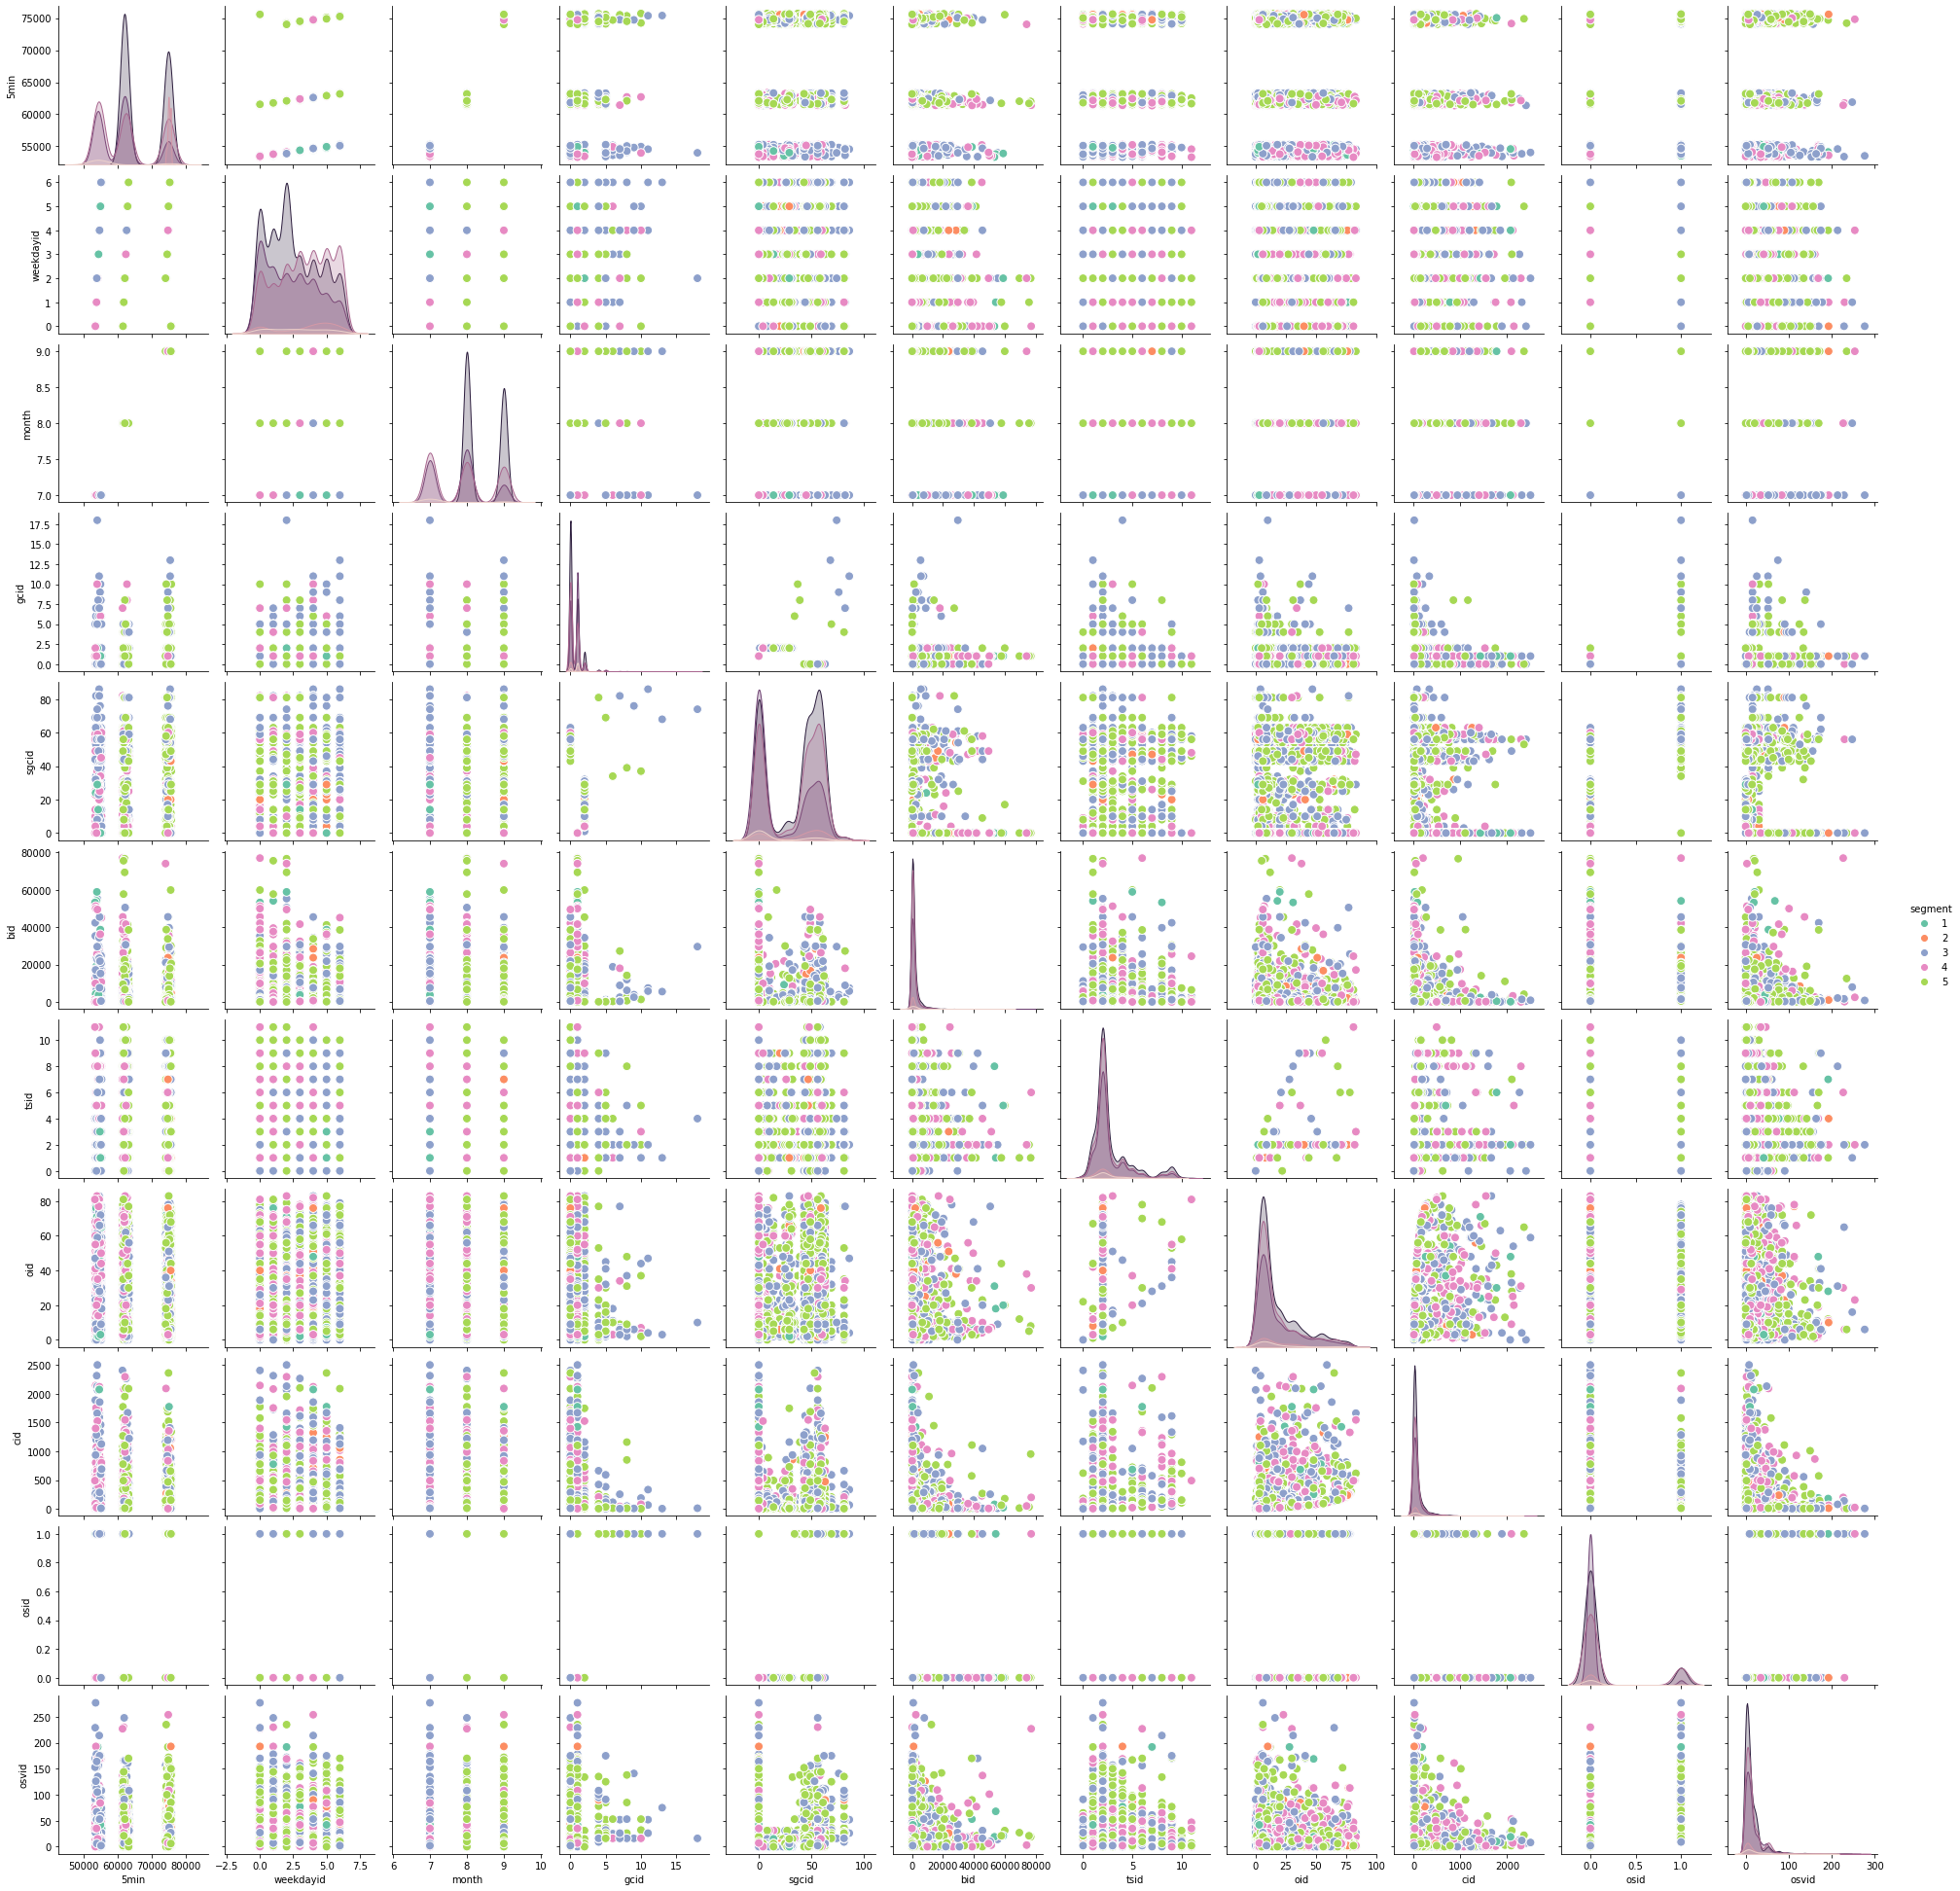

ic| <ipython-input-48-1e7d1bf3d8c8>:6 in <module> at 23:07:20.428


In [48]:
#!c1.8
ic()
my_dpi=96
plt.figure(figsize=(960/my_dpi, 960/my_dpi), dpi=my_dpi)
sns.pairplot(dfr.sample(10000), kind="scatter", hue="segment", plot_kws=dict(s=80, edgecolor="white", linewidth=1, palette='Set2'))
plt.show()
ic()

# Анализ датасета с тестовыми данными

In [49]:
#!c1.8
ic()
df_test = pd.read_csv('test.csv.zip')
ic()

ic| <ipython-input-49-cb1946112bea>:1 in <module> at 23:07:21.401
ic| <ipython-input-49-cb1946112bea>:3 in <module> at 23:07:41.759


In [50]:
#!c1.8
ic()
df_test['date'] = pd.to_datetime(df_test.created).dt.date
df_test['month'] = pd.to_datetime(df_test.created).dt.month
display(df_test.nunique())
ic()

ic| <ipython-input-50-a2c0bd90902e>:1 in <module> at 23:07:51.493


gamecategory            27
subgamecategory         52
bundle               56852
created            1628283
shift                   11
                    ...   
city                  2465
os                       4
osv                    230
date                    21
month                    4
Length: 11, dtype: int64

ic| <ipython-input-50-a2c0bd90902e>:5 in <module> at 23:08:14.649


In [51]:
#!c1.8
df_test

,gamecategory,subgamecategory,bundle,created,shift,oblast,city,os,osv,date,month
0,Applications,Shopping,com.allgoritm.youla,2021-09-19 17:31:33,MSK+2,Свердловская область,Екатеринбург,android,10.0,2021-09-19,9
1,NaN,NaN,com.ChocochocoStd.RapBattle,2021-08-03 17:13:17,MSK+2,Ямало-Ненецкий АО,Новый Уренгой,android,10.0,2021-08-03,8
2,NaN,NaN,1387897651,2021-09-17 15:54:00,MSK,Москва,Москва,ios,14.4.0,2021-09-17,9
3,NaN,NaN,com.cooking.family.diary.fever.food.city.craze...,2021-07-05 23:34:59,MSK,Краснодарский край,Краснодар,android,9.0.0,2021-07-05,7
4,Applications,Health & Fitness,com.pedometer.stepcounter.tracker,2021-07-08 15:15:21,MSK,Татарстан,Набережные Челны,android,10.0,2021-07-08,7
...,...,...,...,...,...,...,...,...,...,...,...
11213624,NaN,NaN,com.phonemaster.jewelhunter,2021-08-04 05:55:26,MSK,Санкт-Петербург,Санкт-Петербург,android,8.1.0,2021-08-04,8
11213625,NaN,NaN,com.linkdesks.jewellegend,2021-09-17 21:45:02,MSK,Ставрополье,Пятигорск,android,10,2021-09-17,9
11213626,Applications,Health & Fitness,com.pedometer.stepcounter.tracker,2021-07-08 10:24:31,MSK+6,Забайкальский Край,Чита,android,11.0,2021-07-08,7
11213627,NaN,NaN,com.onebutton.mrsuper,2021-07-05 16:02:47,MSK+2,Башкортостан,Белорецк,android,6.0.1,2021-07-05,7


ic| <ipython-input-52-78b9c7f4e2b7>:1 in <module> at 23:08:26.071
ic| <ipython-input-52-78b9c7f4e2b7>:4 in <module> at 23:08:32.832
ic| <ipython-input-52-78b9c7f4e2b7>:7 in <module> at 23:08:35.068


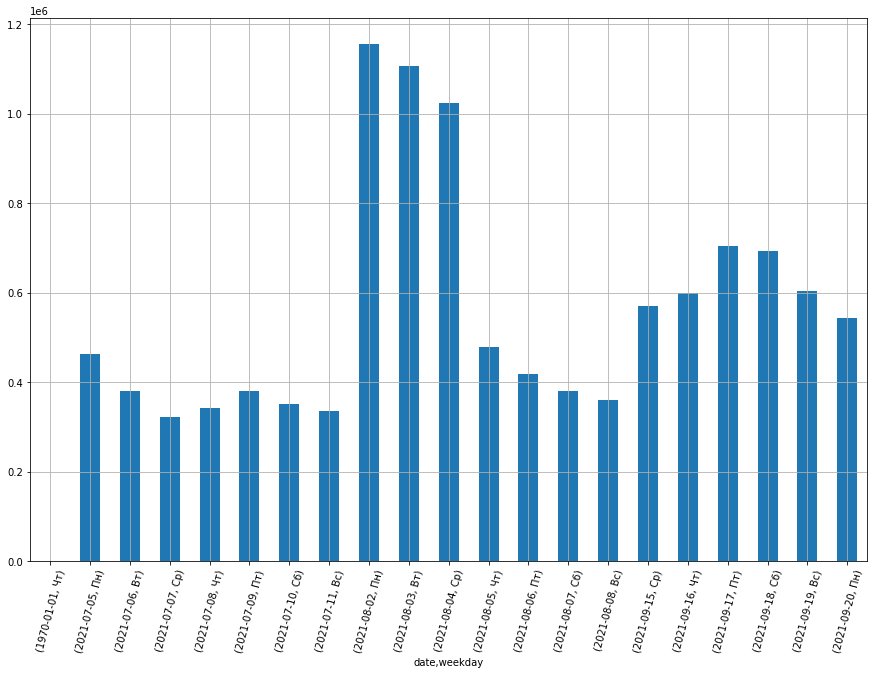

In [52]:
#!c1.8
ic()
df_test['date'] = pd.to_datetime(df_test.created).dt.date
df_test['month'] = pd.to_datetime(df_test.created).dt.month
ic()
# Выделим номер дня недели
df_test['weekdayid'] = pd.to_datetime(df_test.date).dt.weekday
ic()
# Для наглядности определим текстовую метку дня недели
df_test['weekday'] = df_test.weekdayid.map({0: 'Пн', 1: 'Вт', 2: 'Ср', 3: 'Чт', 4: 'Пт', 5: 'Сб', 6: 'Вс'})
ax = df_test.groupby(by=['date', 'weekday']).date.count().plot(grid=True, kind='bar', figsize=(15, 10), rot=75)
plt.show()

In [53]:
#!c1.8
ic()
topoblast = df_test.oblast.value_counts()[:25].index
df_test_topoblast = df_test[df_test.oblast.isin(topoblast)]
tdf = df_test_topoblast.groupby(by=['oblast', 'date']).date.count().unstack().fillna(0)
ic()
tdf['Итого'] = tdf.sum(axis=1)
tdf.sort_values('Итого', ascending=False, inplace=True)
ic()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.1f}'.format
display(tdf/tdf.sum()*100)

ic| <ipython-input-53-96a783cc1717>:1 in <module> at 23:08:51.435
ic| <ipython-input-53-96a783cc1717>:5 in <module> at 23:08:55.307
ic| <ipython-input-53-96a783cc1717>:8 in <module> at 23:08:55.329


date,2021-07-05,2021-07-06,2021-07-07,2021-07-08,2021-07-09,2021-07-10,2021-07-11,2021-08-02,2021-08-03,2021-08-04,2021-08-05,2021-08-06,2021-08-07,2021-08-08,2021-09-15,2021-09-16,2021-09-17,2021-09-18,2021-09-19,2021-09-20,Итого
oblast,,,,,,,,,,,,,,,,,,,,,
Москва,23.6,24.3,24.8,25.0,24.6,23.3,22.7,22.2,22.3,22.2,23.1,23.2,21.5,21.4,23.0,22.4,22.2,21.4,22.5,23.1,22.7
Свердловская область,9.4,9.3,8.8,8.9,9.3,9.6,9.6,8.9,8.8,8.9,8.9,8.9,9.0,9.4,9.2,9.6,9.4,9.3,8.9,9.3,9.1
Санкт-Петербург,9.0,9.2,9.2,9.6,9.9,9.5,9.2,9.5,9.1,8.9,9.0,9.1,8.9,8.4,9.3,8.8,8.8,8.6,9.0,8.9,9.1
Краснодарский край,10.2,9.8,10.0,10.1,10.0,10.0,9.8,9.0,9.1,9.1,8.9,8.9,9.3,9.1,7.9,7.8,7.7,7.6,8.1,7.8,8.9
Татарстан,5.8,5.6,5.6,5.9,5.9,6.0,5.9,6.7,6.8,6.9,6.7,6.6,7.0,6.5,7.3,7.2,7.1,7.0,6.7,6.9,6.6
Новосибирская область,5.5,5.8,5.5,5.3,5.4,5.7,6.0,4.7,4.6,4.7,4.8,4.8,4.6,5.0,4.8,5.1,4.9,5.1,4.8,5.3,5.0
Самарская область,4.8,4.8,4.7,5.0,4.9,5.0,5.0,4.7,4.8,4.8,4.6,4.6,4.7,4.7,4.7,4.6,4.6,4.4,4.3,4.4,4.7
Ростовская область,3.1,3.0,3.0,2.9,3.0,3.0,3.0,3.5,3.5,3.5,3.4,3.4,3.6,3.5,3.1,3.0,3.0,3.1,3.2,3.1,3.2
Московская область,3.0,3.0,3.0,2.8,2.9,2.9,2.9,2.6,2.6,2.7,2.8,3.0,3.0,2.9,2.9,2.9,3.1,3.3,3.6,3.1,2.9


In [54]:
#!c1.8
ic()
topgames = df_test.bundle.value_counts()[:20].index
df_topgames = df_test[df_test.bundle.isin(topgames)]
len(df_topgames)

ic| <ipython-input-54-d96ebabad2f3>:1 in <module> at 23:09:03.992
ic| <ipython-input-54-d96ebabad2f3>:4 in <module> at 23:09:06.705


2364804

In [55]:
#!c1.8
ic()
tdf = df_topgames.groupby(by=['bundle', 'date']).date.count().unstack().fillna(0)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.1f}'.format
display(tdf/tdf.sum()*100)

ic| <ipython-input-55-24e687244ee2>:1 in <module> at 23:09:09.644
ic| <ipython-input-55-24e687244ee2>:3 in <module> at 23:09:10.170


date,2021-07-05,2021-07-06,2021-07-07,2021-07-08,2021-07-09,2021-07-10,2021-07-11,2021-08-02,2021-08-03,2021-08-04,2021-08-05,2021-08-06,2021-08-07,2021-08-08,2021-09-15,2021-09-16,2021-09-17,2021-09-18,2021-09-19,2021-09-20
bundle,,,,,,,,,,,,,,,,,,,,
1300588558,5.2,4.9,5.2,4.4,4.6,5.1,4.4,1.3,1.6,1.6,2.2,2.2,1.7,2.4,2.8,2.7,2.6,2.9,2.8,3.0
351331194,3.0,3.2,3.8,3.4,4.2,5.0,4.8,1.5,1.7,1.7,2.3,2.4,2.0,2.7,3.2,3.0,2.7,2.8,3.4,3.5
com.Seriously.BestFiends,1.4,1.5,1.5,1.8,2.5,2.6,2.4,1.9,2.1,2.1,1.8,1.6,2.0,1.9,2.4,2.7,2.8,2.7,3.0,3.1
com.allgoritm.youla,0.1,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,10.4,10.6,11.2,11.4,13.0
com.axlebolt.standoff2,4.0,4.0,4.2,5.3,5.6,6.0,5.8,11.8,12.9,12.8,9.5,8.6,10.4,9.6,0.6,1.3,0.6,0.3,0.1,0.2
com.fidgettrading.game,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,3.1,3.5,4.0,4.9,6.1,5.3,1.1,1.1,1.4,1.3,1.3,0.9
com.fingerlab.word.blockpuzzles,1.9,1.8,2.2,2.6,3.0,3.1,3.4,4.2,3.9,3.9,4.2,5.1,5.0,4.5,5.1,4.4,3.0,2.5,2.7,2.6
com.fugo.wow,33.6,34.7,31.1,39.9,35.2,28.8,30.2,12.3,12.5,12.5,11.9,11.4,13.2,13.6,9.2,10.0,10.4,10.6,11.5,11.4
com.iposedon.bricksbreakerballs,7.7,7.4,6.1,0.5,0.6,0.7,0.6,5.1,3.9,3.4,3.5,3.7,3.1,3.2,2.1,2.2,2.2,2.0,1.3,2.3


In [ ]:
#!c1.8
